In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
directory = "face_mask/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "face_mask/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("face_mask/train.csv")
df_test = pd.read_csv("face_mask/submission.csv")

Using TensorFlow backend.


In [7]:

cvNet = cv2.dnn.readNetFromCaffe('face_mask/architecture.txt', 'face_mask/weights.caffemodel')
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [8]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '4366.png',
 'NumOfAnno': 2,
 'Annotations': [{'isProtected': False,
   'ID': 7860127655143545,
   'BoundingBox': [396, 9, 810, 542],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 413290516079314560,
   'BoundingBox': [399, 209, 795, 537],
   'classname': 'mask_colorful',
   'Confidence': 1,
   'Attributes': {}}]}

In [9]:
df = pd.read_csv("face_mask/train.csv")

/opt/anaconda/envs/Deepak/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

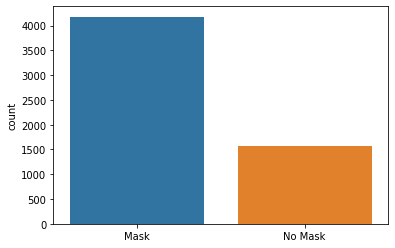

In [10]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)

p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [11]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [18]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)
datagen = ImageDataGenerator(featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=12,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/12
143/143 [==============================] - 15s 108ms/step - loss: 0.3601 - acc: 0.8472 - val_loss: 0.2284 - val_acc: 0.9087
Epoch 2/12
143/143 [==============================] - 14s 97ms/step - loss: 0.2730 - acc: 0.8887 - val_loss: 0.2536 - val_acc: 0.9061
Epoch 3/12
143/143 [==============================] - 14s 98ms/step - loss: 0.2844 - acc: 0.8864 - val_loss: 0.2349 - val_acc: 0.9000
Epoch 4/12
143/143 [==============================] - 14s 98ms/step - loss: 0.2602 - acc: 0.8978 - val_loss: 0.2478 - val_acc: 0.9000
Epoch 5/12
143/143 [==============================] - 14s 98ms/step - loss: 0.2554 - acc: 0.8991 - val_loss: 0.2082 - val_acc: 0.9191
Epoch 6/12
143/143 [==============================] - 14s 98ms/step - loss: 0.2418 - acc: 0.9031 - val_loss: 0.2002 - val_acc: 0.9278
Epoch 7/12
143/143 [==============================] - 14s 98ms/step - loss: 0.2405 - acc: 0.9000 - val_loss: 0.1915 - val_acc: 0.9304
Epoch 8/12
143/143 [==============================] - 14s 96m

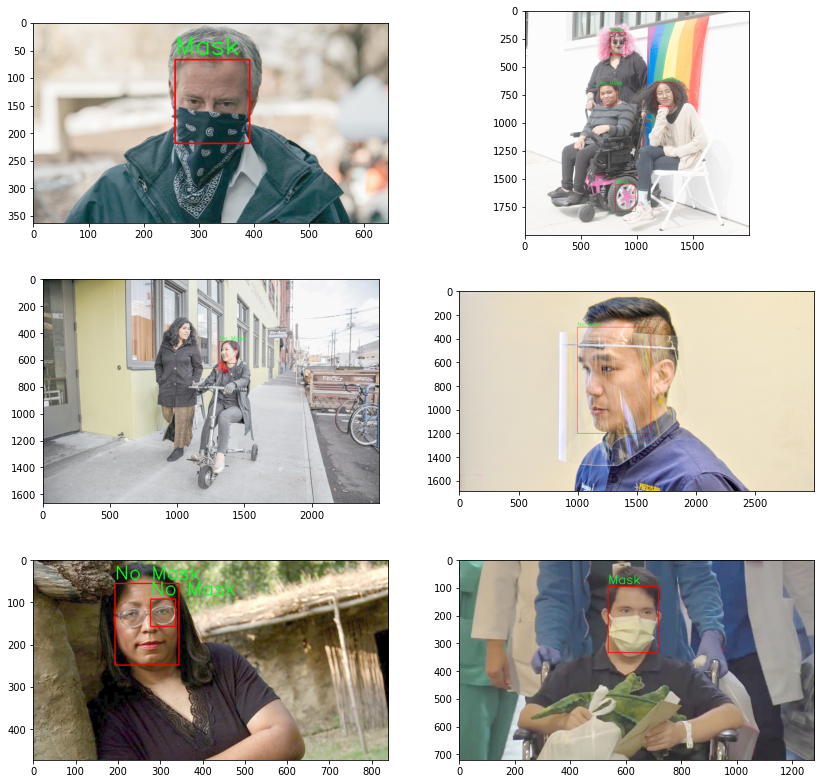

In [37]:

test_images = ['5554.jpg','5555.jpg', '5556.jpg','5557.jpg','5558.jpg','5559.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join('face_mask/test_images/',im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()